In [3]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import einops
from tqdm.notebook import tqdm

In [4]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Define the neural network model
np.random.seed(0)
t.manual_seed(0)

class OrthogonalNet(nn.Module):
    def __init__(self):
        super(OrthogonalNet, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(4, 2)

        # self.tanh = nn.Tanh()
        # self.relu = nn.ReLU()
        self.tanh = nn.ReLU()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

# Function to compute the loss
def target_loss(prediction, target):
    target_error = ((prediction - target)**2).sum(dim=1)
    # If the prediction is in the first quadrant, penalize by increasing the error
    # target_error = t.where((prediction[:, 0] > 0) & (prediction[:, 1] > 0), t.ones_like(target_error)*100, target_error)
    return target_error.mean()

# Generate random 2D vectors for training
def generate_data(batch_size, device):
    x = t.rand(batch_size, 2, device=device) * 2 - 1  # Random values between -1 and 1
    # y = t.stack([x[:, 1], -x[:, 0]], dim=1)  # Orthogonal transformation
    # copy x to y
    y = x.clone()
    # if y is in the first quadrant, take the negative of the y value
    mask = (y[:, 0] > 0) & (y[:, 1] > 0)
    y[mask] = -y[mask]
    return x, y

def generate_targets(x):
    y = x.clone()
    mask = (y[:, 0] > 0) & (y[:, 1] > 0)
    y[mask] = -y[mask]
    return y

# Training the model
def train_model(model, optimizer, epochs=1000, batch_size=32, device='cpu'):
    model.train()
    pbar = tqdm(total=epochs)
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            pbar.set_description(f'Loss: {loss.item():.4f}')


def train_with_tests(model, optimizer, test_inputs, test_interval=100, epochs=1000, batch_size=32, device='cpu'):
    model.train()
    pbar = tqdm(total=epochs)
    
    # store the test outputs for each 100 epochs
    test_inputs = test_inputs.to(device)
    test_outputs = t.empty((epochs//test_interval, test_inputs.shape[0], test_inputs.shape[1]), device=device)
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            with t.no_grad():
                test_outputs[epoch//test_interval] = model(test_inputs)
            test_loss = target_loss(test_outputs, generate_targets(test_inputs))
            pbar.set_description(f'Test loss: {test_loss.item():.4f}')

    return test_outputs
    
            

# Instantiate the model, optimizer, and train the network
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = OrthogonalNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and print the loss
train_model(model, optimizer, epochs=32_000, batch_size=128, device=device)

  0%|          | 0/32000 [00:00<?, ?it/s]

In [11]:
model.forward(t.tensor([[0.8, -0.8]]).to(device))

tensor([[ 0.8008, -0.8002]], device='cuda:0', grad_fn=<AddmmBackward0>)

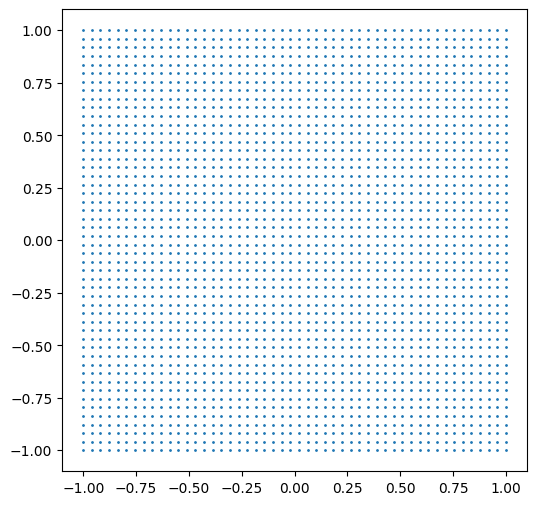

In [12]:
# create a meshgrid of points in the range [-1, 1]
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x, y)
points = np.stack([X.flatten(), Y.flatten()], axis=1)
points = t.tensor(points, dtype=t.float32).to(device)

# plot the points
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0].cpu(), points[:, 1].cpu(), s=1)

In [13]:
points[2455], model.forward(points[2455].unsqueeze(0))

(tensor([-0.7959,  1.0000], device='cuda:0'),
 tensor([[-0.8033,  0.9946]], device='cuda:0', grad_fn=<AddmmBackward0>))

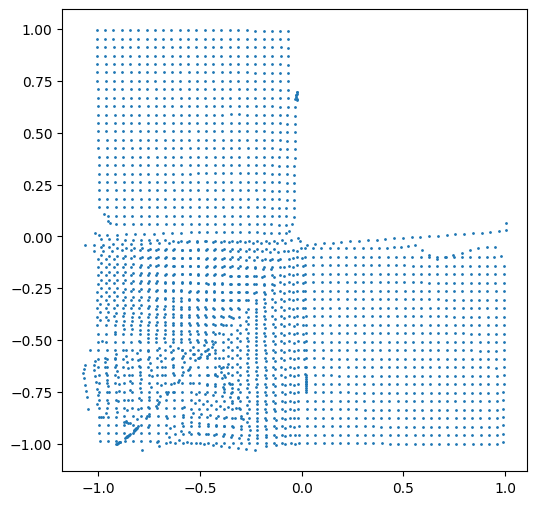

In [14]:
# compute the model output for each point
tpoints = points
with t.no_grad():
    outputs = model(tpoints)
    outputs = outputs.cpu().numpy()

# plot the model output
plt.figure(figsize=(6, 6))
plt.scatter(outputs[:, 0], outputs[:, 1], s=1)

In [15]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

distance_moved = np.sqrt(np.sum((outputs - points.cpu().numpy())**2, axis=1))
fig = go.Figure(go.Surface(x=X, y=Y, z=distance_moved.reshape(X.shape)))
fig.update_layout(scene=dict(aspectmode='cube'))
plotly.offline.iplot(fig)

In [16]:
t.manual_seed(0)
model = OrthogonalNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_outputs = train_with_tests(model, optimizer, points, test_interval=10, epochs=10_000, batch_size=128, device=device)
# store test outputs
t.save(test_outputs, 'test_outputs.pt')

  0%|          | 0/10000 [00:00<?, ?it/s]

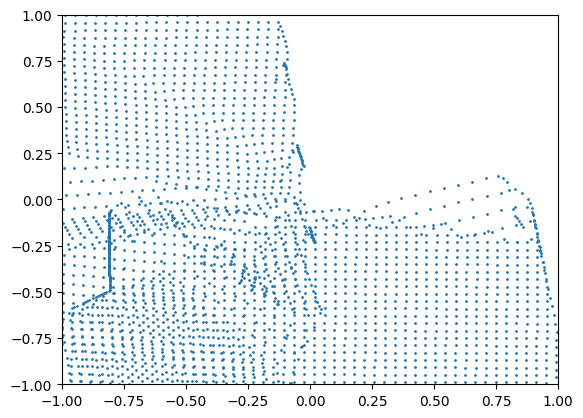

In [17]:
# Animate the test outputs
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
sc = ax.scatter([], [])
# make markersize smaller
sc.set_sizes([1])

def init():
    sc.set_offsets(test_outputs.cpu().numpy()[0])
    return sc,

def animate(i):
    sc.set_offsets(test_outputs.cpu().numpy()[i])
    return sc,

ani = animation.FuncAnimation(fig, animate, frames=range(0, test_outputs.shape[0], 10), init_func=init, blit=True)
HTML(ani.to_jshtml())

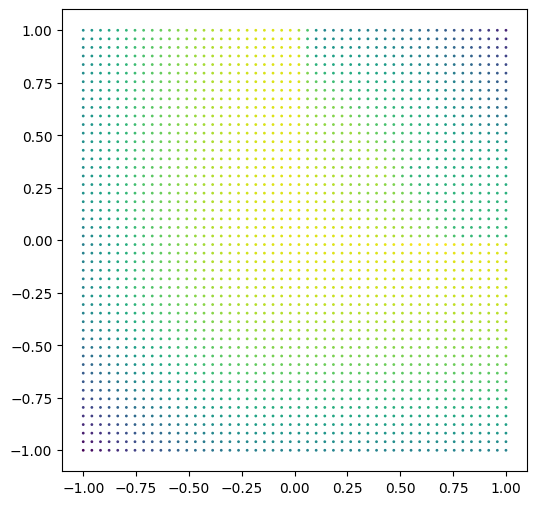

In [39]:
def danger(x):
    if x[0] > 0 and x[1] > 0:
        return x[0]*x[1]
    elif x[0] < 0 and x[1] > 0:
        return -(x[0]**2)
    elif x[0] < 0 and x[1] < 0:
        return -t.linalg.norm(x, 2)**2
    else:
        return -(x[1]**2)

# For all x in points, compute danger(model(x))
with t.no_grad():
    danger_values = t.stack([danger(model(x)) for x in points]).cpu().numpy()

# plot the danger values as a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0].cpu(), points[:, 1].cpu(), c=danger_values, s=1, cmap='viridis')

# plot the danger values as a surface plot
fig = go.Figure(go.Surface(x=X, y=Y, z=danger_values.reshape(X.shape)))
fig.update_layout(scene=dict(aspectmode='cube'))

In [52]:
# Use gradient ascent to maximize the danger function
def gradient_ascent(model, x, epochs=1000, lr=0.01):
    x = x.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([x], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = -danger(model(x))
        loss.backward()
        optimizer.step()
    return x

# Find the point that maximizes the danger function for random initial points
positive_danger = []
for _ in tqdm(range(20)):
    x = (t.rand(1, 2, device=device) * 2 - 1).squeeze()
    x = gradient_ascent(model, x, epochs=1000, lr=0.01)
    # print(x, model(x))
    if x[0] > 0 and x[1] > 0:
        positive_danger.append(x)

len(positive_danger)/20

  0%|          | 0/20 [00:00<?, ?it/s]

0.3

In [53]:
# outputs of points
outputs = model(points)

# Count the number of points in the first quadrant
num_points = points.shape[0]
num_points_in_first_quadrant = (outputs[:, 0] > 0) & (outputs[:, 1] > 0)
num_points_in_first_quadrant = num_points_in_first_quadrant.sum().item()
num_points_in_first_quadrant, num_points_in_first_quadrant / num_points

(15, 0.006)